https://langchain-ai.github.io/langgraph/tutorials/workflows/#prompt-chaining

In [15]:
import os
import getpass
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o-mini')

In [10]:
# Schema for structured output
from pydantic import BaseModel, Field

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Query that is optimized web search.")
    justification: str = Field(
        None, description="Why this query is relevant to the user's request."
    )


# Augment the LLM with schema for structured output
structured_llm = llm.with_structured_output(SearchQuery)

# Invoke the augmented LLM
output = structured_llm.invoke("How does Calcium CT score relate to high cholesterol?")

# Define a tool
def multiply(a: int, b: int) -> int:
    return a * b

# Augment the LLM with tools
llm_with_tools = llm.bind_tools([multiply])

# Invoke the LLM with input that triggers the tool call
msg = llm_with_tools.invoke("What is 2 times 3?")

# Get the tool call
msg.tool_calls

[{'name': 'multiply',
  'args': {'a': 2, 'b': 3},
  'id': 'call_H9IZeetMpy6eLzQziJCoZw16',
  'type': 'tool_call'}]

このコードは、ジョーク生成とその評価を繰り返すワークフローを定義しています。以下に各部分の解説を示します。

1. **状態とスキーマの定義**  
   - **State (状態) クラス**  
     - `joke`: 生成されたジョークの内容を保持する文字列  
     - `topic`: ジョークの題材（例："Cats"）  
     - `feedback`: 改善のためのフィードバック（初回は空の場合もある）  
     - `funny_or_not`: 評価結果を格納し、「funny」または「not funny」を示す  
   - **Feedback クラス**  
     - こちらは評価結果のスキーマを定義しています。ジョークが面白いかどうか（`grade`）と、面白くない場合の改善フィードバック（`feedback`）が含まれます。

2. **LLM（大規模言語モデル）の強化**  
   - `evaluator = llm.with_structured_output(Feedback)`  
     - この行では、評価ノードが構造化された出力（`Feedback`クラス）を返すようにLLMを拡張しています。

3. **ノードの定義**  
   - **llm_call_generator**  
     - この関数は、指定されたトピックに基づいてジョークを生成します。  
     - 初回またはフィードバックがない場合は「Write a joke about [topic]」とLLMに指示し、フィードバックがある場合はそのフィードバックを考慮したジョーク生成を行います。
   - **llm_call_evaluator**  
     - この関数は、生成されたジョークを評価します。  
     - LLMを用いてジョークの評価を行い、「funny」または「not funny」とその理由（フィードバック）を返します。

4. **条件分岐関数**  
   - **route_joke**  
     - 評価結果に基づき、次のステップを決定します。  
     - `funny` ならば「Accepted」としてワークフローを終了し、`not funny` ならば「Rejected + Feedback」としてフィードバックを反映し、再度ジョーク生成ノードへループします。

5. **ワークフローの構築**  
   - **StateGraph の利用**  
     - `optimizer_builder = StateGraph(State)` により状態管理用のグラフが作成されます。  
     - `llm_call_generator` と `llm_call_evaluator` の２つのノードをグラフに追加しています。
   - **エッジの定義**  
     - ワークフローの開始点からジョーク生成ノードに、生成ノードから評価ノードに、さらに評価結果に応じた条件付きエッジ（`route_joke` 関数を使用）を設定しています。  
     - 評価が「Accepted」の場合はワークフローを終了し、「Rejected + Feedback」の場合は再びジョーク生成へと戻ります。

6. **ワークフローの実行と結果表示**  
   - ワークフローは `optimizer_workflow = optimizer_builder.compile()` によってコンパイルされ、グラフの画像が表示されます。  
   - 最後に、`optimizer_workflow.invoke({"topic": "Cats"})` によって、「Cats」という題材でジョーク生成プロセスが開始され、最終的に生成されたジョークが表示されます。

この仕組みにより、LLMを用いて動的にジョークを生成し、評価とフィードバックを反映しながら、面白いジョークが完成するまで繰り返すプロセスを自動化しています。

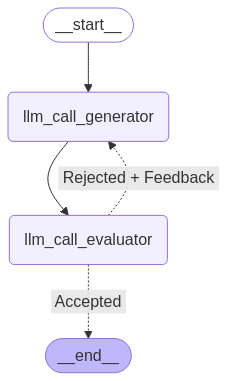

Why did the cat sit on the computer?

Because it wanted to keep an eye on the mouse!


In [16]:
from typing_extensions import TypedDict, Literal
from IPython.display import Image, display

# Graph state
class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str


# Schema for structured output to use in evaluation
class Feedback(BaseModel):
    grade: Literal["funny", "not funny"] = Field(
        description="Decide if the joke is funny or not.",
    )
    feedback: str = Field(
        description="If the joke is not funny, provide feedback on how to improve it.",
    )


# Augment the LLM with schema for structured output
evaluator = llm.with_structured_output(Feedback)


# Nodes
def llm_call_generator(state: State):
    """LLM generates a joke"""

    if state.get("feedback"):
        msg = llm.invoke(
            f"Write a joke about {state['topic']} but take into account the feedback: {state['feedback']}"
        )
    else:
        msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}


def llm_call_evaluator(state: State):
    """LLM evaluates the joke"""

    grade = evaluator.invoke(f"Grade the joke {state['joke']}")
    return {"funny_or_not": grade.grade, "feedback": grade.feedback}


# Conditional edge function to route back to joke generator or end based upon feedback from the evaluator
def route_joke(state: State):
    """Route back to joke generator or end based upon feedback from the evaluator"""

    if state["funny_or_not"] == "funny":
        return "Accepted"
    elif state["funny_or_not"] == "not funny":
        return "Rejected + Feedback"


# Build workflow
optimizer_builder = StateGraph(State)

# Add the nodes
optimizer_builder.add_node("llm_call_generator", llm_call_generator)
optimizer_builder.add_node("llm_call_evaluator", llm_call_evaluator)

# Add edges to connect nodes
optimizer_builder.add_edge(START, "llm_call_generator")
optimizer_builder.add_edge("llm_call_generator", "llm_call_evaluator")
optimizer_builder.add_conditional_edges(
    "llm_call_evaluator",
    route_joke,
    {  # Name returned by route_joke : Name of next node to visit
        "Accepted": END,
        "Rejected + Feedback": "llm_call_generator",
    },
)

# Compile the workflow
optimizer_workflow = optimizer_builder.compile()

# Show the workflow
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))

# Invoke
state = optimizer_workflow.invoke({"topic": "Cats"})
print(state["joke"])

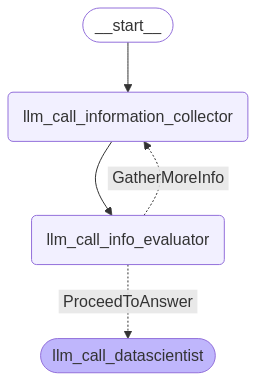

llm_call_information_collector 緑茶は健康に多くの有益な効果があるとされ、様々な研究が行われています。以下は緑茶の主な健康効果についての情報です。

1. **抗酸化作用**: 緑茶にはカテキンというポリフェノールが豊富に含まれており、これは強い抗酸化作用を持っています。抗酸化物質は活性酸素を中和し、細胞の損傷を防ぐのに役立ちます。

2. **心血管の健康**: 緑茶の定期的な摂取は、心臓病や脳卒中のリスクを低下させる可能性があるとされています。研究によると、緑茶が血圧を下げたり、コレステロール値を改善したりすることが示されています。

3. **体重管理**: 緑茶は代謝を促進し、脂肪燃焼を助けるため、体重管理やダイエットのサポートに役立つとされています。特に、運動前に緑茶を摂取することで、脂肪の酸化が促進されることがあります。

4. **糖尿病予防**: いくつかの研究では、緑茶の摂取が2型糖尿病のリスクを低下させる可能性があることが示唆されています。血糖値のコントロールやインスリン感受性の向上に寄与することが考えられています。

5. **抗菌作用**: 緑茶には抗菌作用があり、口内のバイ菌の抑制や、歯周病予防に寄与することが示されています。また、喉の痛みや風邪の予防にも効果があるとされています。

6. **脳の健康**: 緑茶に含まれるL-テアニンやカフェインは、集中力や注意力を高める効果があり、認知機能の改善にも寄与する可能性があります。また、アルツハイマー病やパーキンソン病の予防に役立つかもしれないとも言われています。

7. **ストレス軽減**: L-テアニンはリラックス効果があるため、ストレスや不安を軽減するのに役立つとされています。

これらの健康効果は、特に緑茶を定期的に飲むことで得られると考えられています。ただし、健康効果には個人差があり、過剰摂取は逆効果になりうるため、適量を守ることが重要です。また、医療的な問題がある場合は、専門医の意見を求めることをお勧めします。
llm_call_info_evaluator 緑茶の健康効果に関する情報は包括的であり、抗酸化作用からストレス軽減まで多岐にわたっています。これにより、ユーザーの質問に対して十分な回答が提供されています。ただし、限定的な情報として、研究の出

In [18]:
from typing_extensions import TypedDict, Literal
from IPython.display import Image, display
from pydantic import BaseModel, Field

# Graph state
class State(TypedDict):
    question: str            # ユーザーからの質問
    collected_info: str      # 情報収集LLMが集めた情報
    feedback: str            # 評価者からの追加情報の要求内容（必要な場合）
    evaluation: str          # 評価結果："sufficient"（十分） or "needs more info"（追加情報が必要）

# Schema for structured output to use in evaluation
class InfoFeedback(BaseModel):
    grade: Literal["sufficient", "needs more info"] = Field(
        description="収集した情報が質問に回答するのに十分か、追加情報が必要かを判定します。",
    )
    feedback: str = Field(
        description="情報が不十分な場合、どのような追加情報が必要かを示します。",
    )

# Augment the LLM with schema for structured output
evaluator = llm.with_structured_output(InfoFeedback)

# ノード
def llm_call_information_collector(state: State):
    """ユーザーの質問に対して情報収集を行うLLMノード"""
    if state.get("feedback"):
        msg = llm.invoke(
            f"ユーザーの質問「{state['question']}」に対して、以下のフィードバックを考慮して追加情報を収集してください: {state['feedback']}"
        )
    else:
        msg = llm.invoke(f"ユーザーの質問「{state['question']}」に対して情報を収集してください。")
    print('llm_call_information_collector', msg.content)
    return {"collected_info": msg.content}

def llm_call_info_evaluator(state: State):
    """収集した情報が十分かどうかを評価するLLMノード"""
    result = evaluator.invoke(
        f"ユーザーの質問「{state['question']}」に対して、以下の情報は回答に十分かを評価してください: {state['collected_info']}"
    )
    print('llm_call_info_evaluator', result.feedback)
    return {"evaluation": result.grade, "feedback": result.feedback}

def route_info(state: State):
    """評価結果に基づき、情報収集ノードに戻るかdatacientistノードに進むかを決定する"""
    print('route_info', state["evaluation"])
    if state["evaluation"] == "sufficient":
        return "ProceedToAnswer"
    elif state["evaluation"] == "needs more info":
        return "GatherMoreInfo"

def llm_call_datascientist(state: State):
    """収集した情報を基に、ユーザーの質問に対して最終回答を生成するLLMノード"""
    msg = llm.invoke(
        f"以下の情報を元に、ユーザーの質問「{state['question']}」に回答してください: {state['collected_info']}"
    )
    print('llm_call_datascientist', msg.content)
    return {"answer": msg.content}

# ワークフロー構築
optimizer_builder = StateGraph(State)

# ノードの追加
optimizer_builder.add_node("llm_call_information_collector", llm_call_information_collector)
optimizer_builder.add_node("llm_call_info_evaluator", llm_call_info_evaluator)
optimizer_builder.add_node("llm_call_datascientist", llm_call_datascientist)

# エッジの追加
optimizer_builder.add_edge(START, "llm_call_information_collector")
optimizer_builder.add_edge("llm_call_information_collector", "llm_call_info_evaluator")
optimizer_builder.add_conditional_edges(
    "llm_call_info_evaluator",
    route_info,
    {  
        "GatherMoreInfo": "llm_call_information_collector",
        "ProceedToAnswer": "llm_call_datascientist",
    },
)

# ワークフローのコンパイル
optimizer_workflow = optimizer_builder.compile()

# ワークフローのグラフを表示
display(Image(optimizer_workflow.get_graph().draw_mermaid_png()))

# ワークフローの実行例（ユーザーからの質問をStateに渡す）
state = optimizer_workflow.invoke({"question": "緑茶の健康効果について教えてください。"})
print(state.get("answer", "回答が生成されていません。"))
